The challenge in this competition is to classify the type of ovarian cancer from microscopy scans of biopsy samples.


### TASK : image classification (multiclass)

### Setup and Imports



In [43]:
import sys

In [44]:
import tensorflow as tf 
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import pandas as pd
import matplotlib.pyplot as plt
#import datasets 
import numpy as np 
import sklearn as skl

=pretrained model =  
microsoft/resnet-18"



In [45]:
# load data 
train_csv = pd.read_csv("/kaggle/input/UBC-OCEAN/train.csv")

In [46]:
# count files 
import os

#n_files = 0
#for _, _, files_list in os.walk('/kaggle/input/UBC-OCEAN/train_images'):
     #n_files += len(files_list)
#print('file count:', count)


In [47]:
source = '/kaggle/input/UBC-OCEAN/train_thumbnails/'

files_list = os.listdir(source)
labels = sorted(train_csv["label"].unique().tolist())
labels_list = train_csv["label"].tolist()

In [48]:
train_csv.count()

image_id        538
label           538
image_width     538
image_height    538
is_tma          538
dtype: int64

538 files 

In [49]:
train_csv.nunique()

image_id        538
label             5
image_width     508
image_height    508
is_tma            2
dtype: int64

5 distinct labels 

In [50]:
train_csv['label'].value_counts()

label
HGSC    222
EC      124
CC       99
LGSC     47
MC       46
Name: count, dtype: int64

In [51]:
n_files = len(files_list)

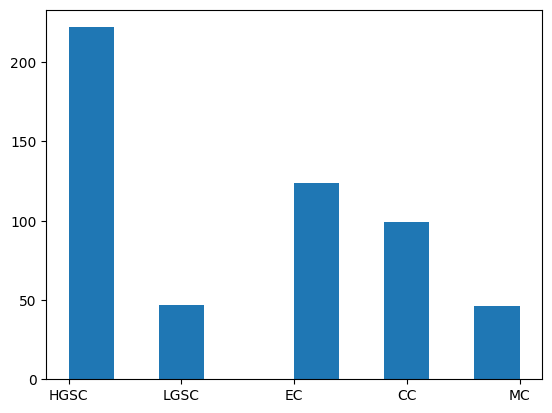

In [52]:
#plt.figure()
_=plt.hist(train_csv["label"])

In [53]:
train_csv['image_id_path'] = [f"{i}_thumbnail.png" for i in train_csv['image_id']]

In [54]:
!mkdir ./train

mkdir: cannot create directory ‘./train’: File exists


In [55]:
!mkdir /kaggle/working/train/HGSC/ \
/kaggle/working/train/LGSC/ \
/kaggle/working/train/CC/ \
/kaggle/working/train/MC/ \
/kaggle/working/train/EC/

mkdir: cannot create directory ‘/kaggle/working/train/HGSC/’: File exists
mkdir: cannot create directory ‘/kaggle/working/train/LGSC/’: File exists
mkdir: cannot create directory ‘/kaggle/working/train/CC/’: File exists
mkdir: cannot create directory ‘/kaggle/working/train/MC/’: File exists
mkdir: cannot create directory ‘/kaggle/working/train/EC/’: File exists


In [56]:
# fill sub-folders 
# split images into subfolders
import shutil
i=0
dest = "/kaggle/working/train/"
for file in files_list :
    if ((file not in labels) and (file not in os.listdir(f'{dest}{labels_list[i]}/'))):
        shutil.copy(
           f"{source}{file}",
           f'{dest}{labels_list[i]}/'
           )
i += 1

 Create datasets 

In [57]:
# create data sets
# train_dir = './train_thumbnails/'

BATCH_SIZE = 32
# IMG_SIZE = (160, 160)
IMG_SIZE = (128, 128)

train_dataset = tf.keras.utils.image_dataset_from_directory('/kaggle/working/train',
                                                            labels = "inferred",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            subset ="training",
                                                            validation_split = 0.2,
                                                            seed = 123)

Found 513 files belonging to 5 classes.
Using 411 files for training.


In [58]:
# create data sets
# train_dir = './train_thumbnails/'

BATCH_SIZE = 32
# IMG_SIZE = (160, 160)
IMG_SIZE = (128, 128)

validation_dataset = tf.keras.utils.image_dataset_from_directory('/kaggle/working/train',
                                                            labels = "inferred",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            subset ="validation",
                                                            validation_split = 0.2,
                                                            seed = 123)

Found 513 files belonging to 5 classes.
Using 102 files for validation.


## Data visualization

In [59]:
import matplotlib.pyplot as plt 
class_names = train_dataset.class_names

#plt.figure(figsize=(5, 5))
#for images, labels in train_dataset.take(4):
      #for i in range(4):
            # print(class_names[labels[i]])
           # ax = plt.subplot(2, 2, i + 1)
            #img0 = plt.imread(images[i])
            #plt.imshow(img0.numpy().astype("uint8"))
            #plt.title(class_names[labels[i]])
            #plt.axis("off")

In [60]:
# image batch 
#for image_batch, labels_batch in train_dataset:
      #print(image_batch.shape)
      #print(labels_batch.shape)
     # break

===

In [61]:
# Configure datasets for perf
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [62]:
#  augmentation layers
data_augmentation = tf.keras.Sequential([
tf.keras.layers.RandomFlip('horizontal'),
tf.keras.layers.RandomFlip('vertical'),
tf.keras.layers.RandomFlip('horizontal_and_vertical'),
tf.keras.layers.RandomRotation(factor=0.2),
tf.keras.layers.RandomBrightness(0.2),
#new added layers
tf.keras.layers.RandomCrop(IMG_SIZE[0], IMG_SIZE[1]),
tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1)
])

In [63]:
# hub layer 
hub_layer = hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2",
                   output_shape=(None,5),
    trainable = False)

In [64]:
# add a global spatial average pooling layer
inputs = keras.Input(shape=(None, None, 3))
x = data_augmentation(inputs)
x = hub_layer(inputs)
#x = Dense(512, activation='relu',kernel_regularizer = "l2")(x)
#x = tf.keras.layers.Dropout(0.1)(x)
x = Dense(256, activation='relu',kernel_regularizer = "l2")(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = Dense(128, activation='relu',kernel_regularizer = "l2")(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = Dense(64, activation='relu',kernel_regularizer = "l2")(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = Dense(32, activation='relu',kernel_regularizer = "l2")(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = Dense(16, activation='relu',kernel_regularizer = "l2")(x)
x = tf.keras.layers.Dropout(0.1)(x)
# predictions layer
predictions = Dense(5, activation='softmax')(x)

In [65]:
# model 
model = Model(inputs= inputs, outputs=predictions)

In [66]:
#model.summary()

In [67]:
model.compile(optimizer = 'Adam',
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics = "Accuracy")

In [68]:
train_batches = train_dataset.cardinality().numpy()
val_batches = validation_dataset.cardinality().numpy()

print(f"num batches : {train_batches}")

num batches : 13


In [69]:
# create class weights
weights = skl.utils.class_weight.compute_class_weight('balanced',
                                                      classes = labels,
                                                    #    y=[class_names[id] for id in labels_train.numpy()] )
                                                       y= labels_list
                                                    )
class_weights = {i: round(weights[i],2) for i in range(5) }
class_weights


{0: 1.09, 1: 0.87, 2: 0.48, 3: 2.29, 4: 2.34}

===

In [70]:
history = model.fit(train_dataset,
                         validation_data = validation_dataset,
                         class_weight = class_weights,
                        epochs = 10)

Epoch 1/10
13/13 [==============================] - 43s 1s/step - loss: 6.5186 - Accuracy: 0.9440 - val_loss: 5.4336 - val_Accuracy: 1.0000
Epoch 2/10
13/13 [==============================] - 36s 1s/step - loss: 4.6547 - Accuracy: 0.9976 - val_loss: 3.8062 - val_Accuracy: 1.0000
Epoch 3/10
13/13 [==============================] - 37s 1s/step - loss: 3.2436 - Accuracy: 1.0000 - val_loss: 2.6504 - val_Accuracy: 1.0000
Epoch 4/10
13/13 [==============================] - 36s 1s/step - loss: 2.2715 - Accuracy: 1.0000 - val_loss: 1.8762 - val_Accuracy: 1.0000
Epoch 5/10
13/13 [==============================] - 37s 1s/step - loss: 1.6291 - Accuracy: 1.0000 - val_loss: 1.3664 - val_Accuracy: 1.0000
Epoch 6/10
13/13 [==============================] - 36s 1s/step - loss: 1.2027 - Accuracy: 1.0000 - val_loss: 1.0255 - val_Accuracy: 1.0000
Epoch 7/10
13/13 [==============================] - 36s 1s/step - loss: 0.9143 - Accuracy: 1.0000 - val_loss: 0.7909 - val_Accuracy: 1.0000
Epoch 8/10
13/13 [==

In [71]:
# predict 
#pred = model.predict()

===

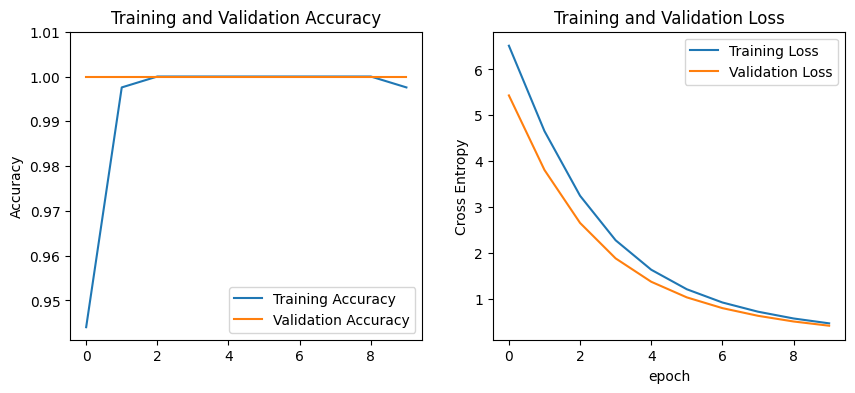

In [72]:
# plot training and validation metrics
import matplotlib.pyplot as plt
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.01])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,4])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [73]:
IMG_SIZE = (128, 128)
#label =[]
def read_image_n_predict(image_path :str, labels):
    #for path  in images_path:
    image = tf.keras.utils.load_img(image_path,target_size = IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(image)
    img_exp = np.expand_dims(img_array,axis = 0)
            
    # predict
    pred0 =  model.predict(img_exp)
    index= np.argmax(pred0)

    # retrieve label 
    label = labels[index]
    return label
        


In [74]:
test_csv = pd.read_csv("/kaggle/input/UBC-OCEAN/test.csv")
image_id = test_csv["image_id"]

# labels
labels_pred = []
files = os.listdir("/kaggle/input/UBC-OCEAN/test_thumbnails")
for i in range(len(files)) :
    img_path = f"/kaggle/input/UBC-OCEAN/test_thumbnails/{files[i]}"
    labels_pred.append(read_image_n_predict(img_path,class_names))

1/1 [==============================] - 1s 560ms/step


In [75]:
labels_pred 

['HGSC']

In [76]:
submission_file = pd.DataFrame()
submission_file['image_id'] = [41]
submission_file['label'] = [label for label in labels_pred]

submission_file.to_csv("submission.csv",index = False, index_label=False)